In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=99999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(ggthemes)
library(ggrepel)
library(reshape2)

library(quantmod)
library(PerformanceAnalytics)

options(repr.plot.width=16, repr.plot.height=8)

## What is the "average" annual returns of NIFTY 50 TR?

In [2]:
indexName <- "NIFTY 50 TR"
indices <- Indices()

nifty <- indices$NseTimeSeries() %>%
    filter(NAME == indexName) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

annRets <- annualReturn(xts(nifty$CLOSE, nifty$TIME_STAMP))
annRets <- annRets[-1,]
annRets <- annRets[-nrow(annRets),]

In [3]:
print("life-time:")
print(summary(annRets))

print("since 2010:")
print(summary(annRets["2010/"]))

[1] "life-time:"
     Index            yearly.returns     
 Min.   :2000-12-29   Min.   :-0.512715  
 1st Qu.:2005-07-01   1st Qu.: 0.006909  
 Median :2009-12-31   Median : 0.130355  
 Mean   :2009-12-30   Mean   : 0.174914  
 3rd Qu.:2014-07-01   3rd Qu.: 0.357662  
 Max.   :2018-12-31   Max.   : 0.775908  
[1] "since 2010:"
     Index            yearly.returns    
 Min.   :2010-12-31   Min.   :-0.23808  
 1st Qu.:2012-12-31   1st Qu.: 0.04395  
 Median :2014-12-31   Median : 0.08072  
 Mean   :2014-12-30   Mean   : 0.11345  
 3rd Qu.:2016-12-30   3rd Qu.: 0.29435  
 Max.   :2018-12-31   Max.   : 0.32899  


## Setup the scenarios

Here, we consider only STT (Securities Transaction Tax) and do not consider impact cost, brokerage and other fees.

In [18]:
numPeriods <- 10
totalChurn <- seq(from=0.0, to=0.90, by=0.15)
churn <- t(matrix(rep(totalChurn, numPeriods), ncol=numPeriods)) # if fund turnover is x, then churn is 2x. 
# Portfolio turnover is calculated by dividing either the total purchases or total sales, whichever is lower, by the average of the net assets. https://svz.bz/2mnc5UV 
cost <- rep(0.1, numPeriods) # STT
dates <- seq(from=as.Date("2000-01-01"), by="year", length.out=numPeriods + 1)

In [19]:
doScenarioAnalysis <- function(annualReturn){
    returns <- rep(annualReturn, numPeriods)
    scenario <- apply(churn, 2, function(ch) cumprod(1 + returns - cost*ch))
    scenario <- rbind(rep(1, ncol(churn)), scenario)
                      
    scenDf <- data.frame(scenario)
    names(scenDf) <- sapply(totalChurn, function(x) sprintf("x %.2f", x*100))
    scenDf$T <- seq(1, by=1, length.out=nrow(scenario))
    toPlot <- melt(scenDf, id='T')
                            
    ggplot(toPlot, aes(x = T, y = value, color = variable)) + 
        theme_economist() +
        geom_line() + 
        geom_text_repel(data=subset(toPlot, T == max(T)), aes(label=round(value,2)), show.legend = F) +
        geom_hline(yintercept = 1, col='grey') +
        labs(x='', y='growth of Rs. 1', fill='', color='churn(%)',
             title="Transaction cost analysis", 
             subtitle=sprintf("notional returns: %.2f%%", annualReturn*100)) +
        annotate("text", x=numPeriods, y=min(scenario, na.rm=T), label = "@StockViz", 
                 hjust=0, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)
}

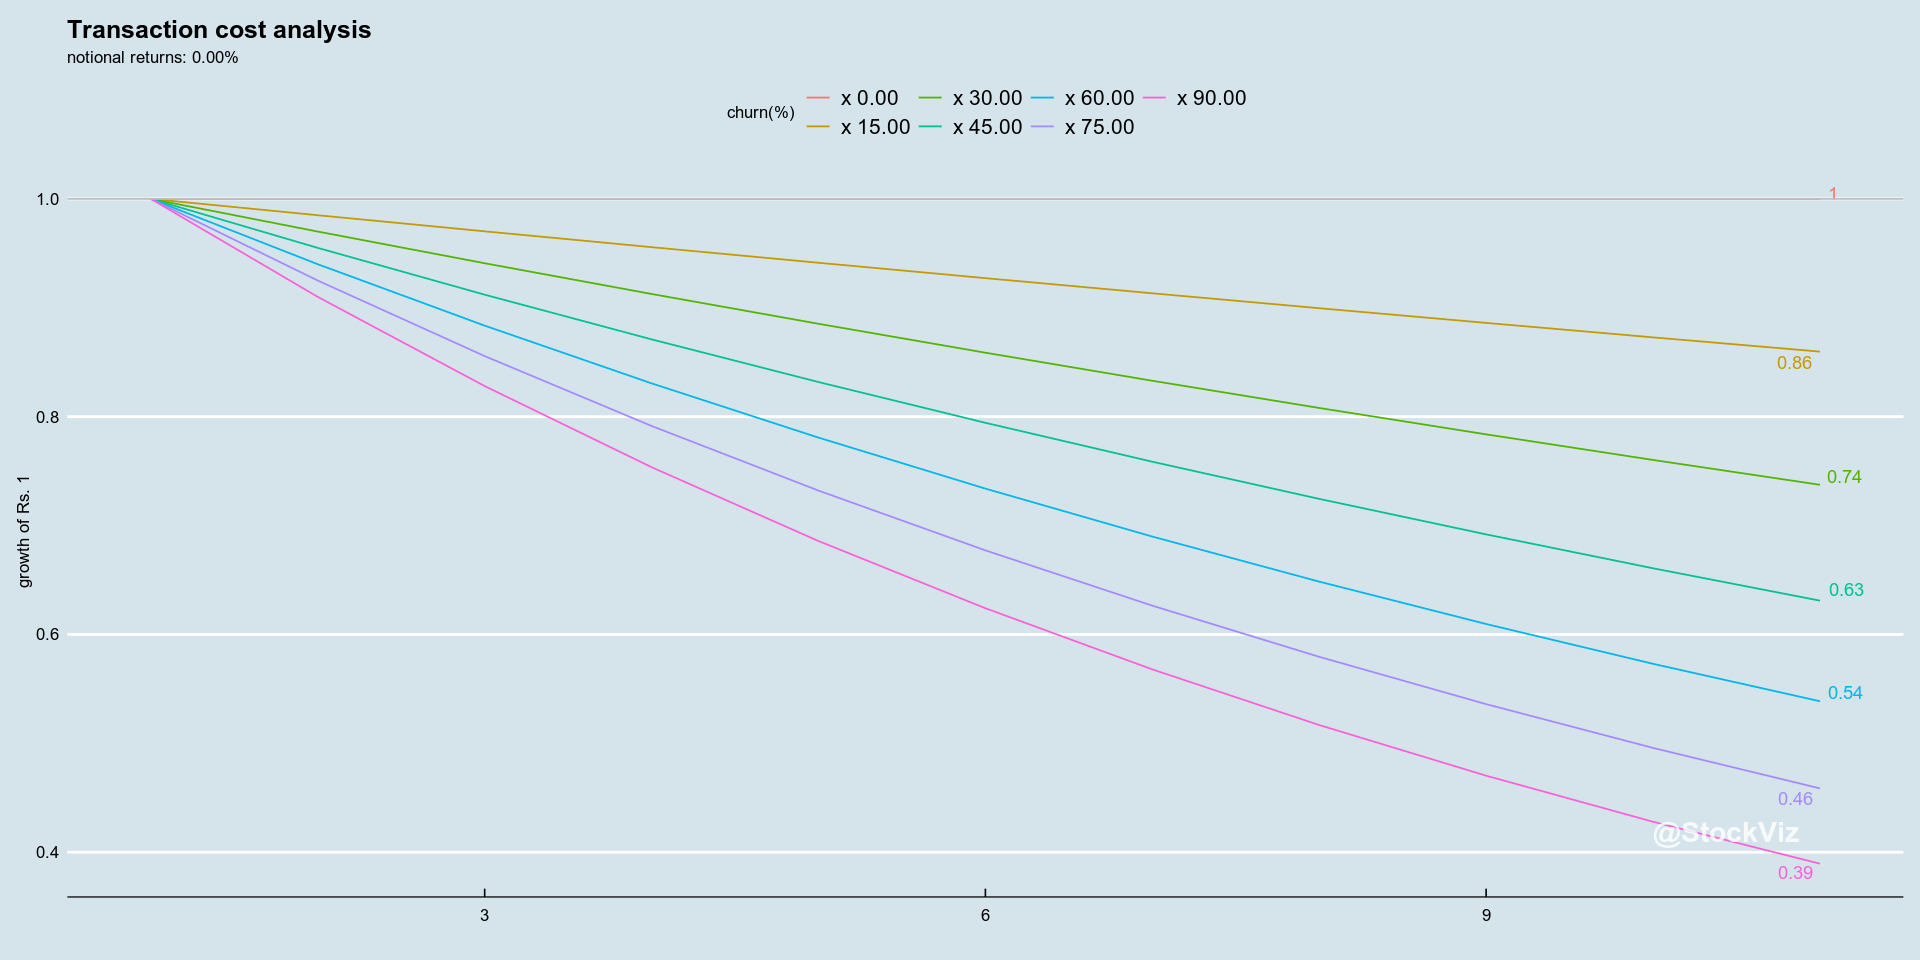

In [20]:
doScenarioAnalysis(0)

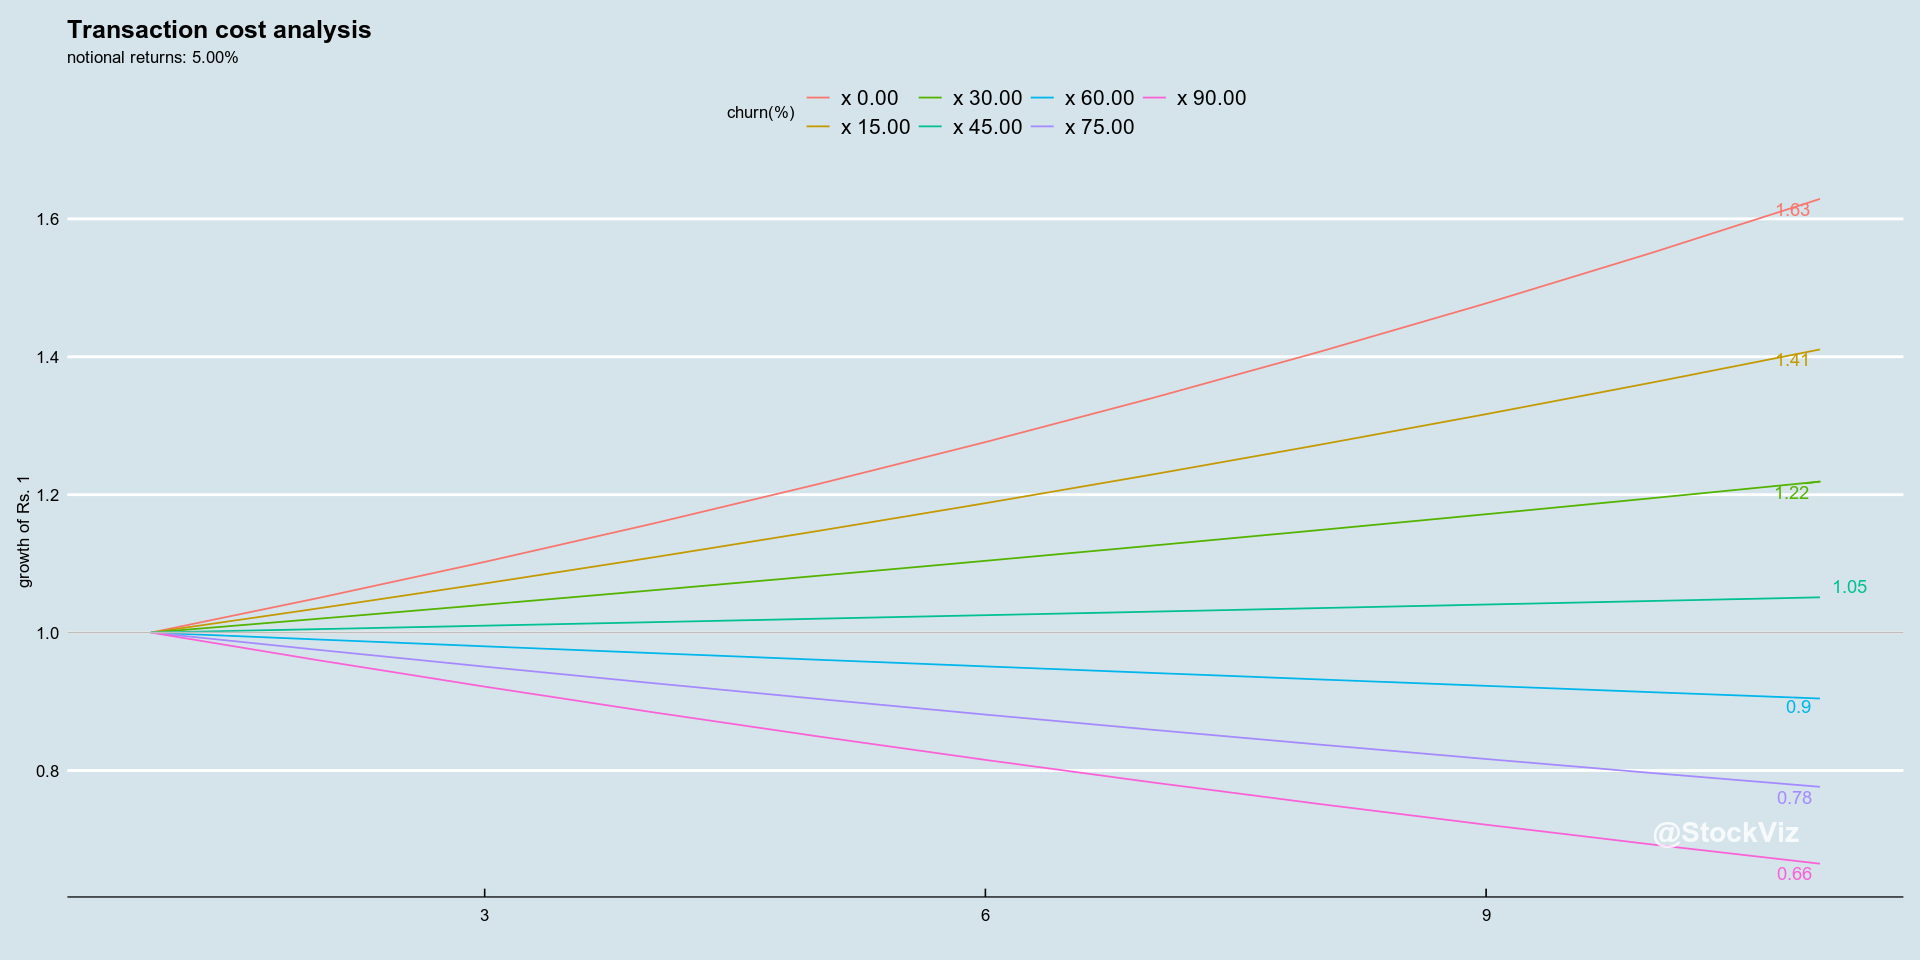

In [21]:
doScenarioAnalysis(0.05)

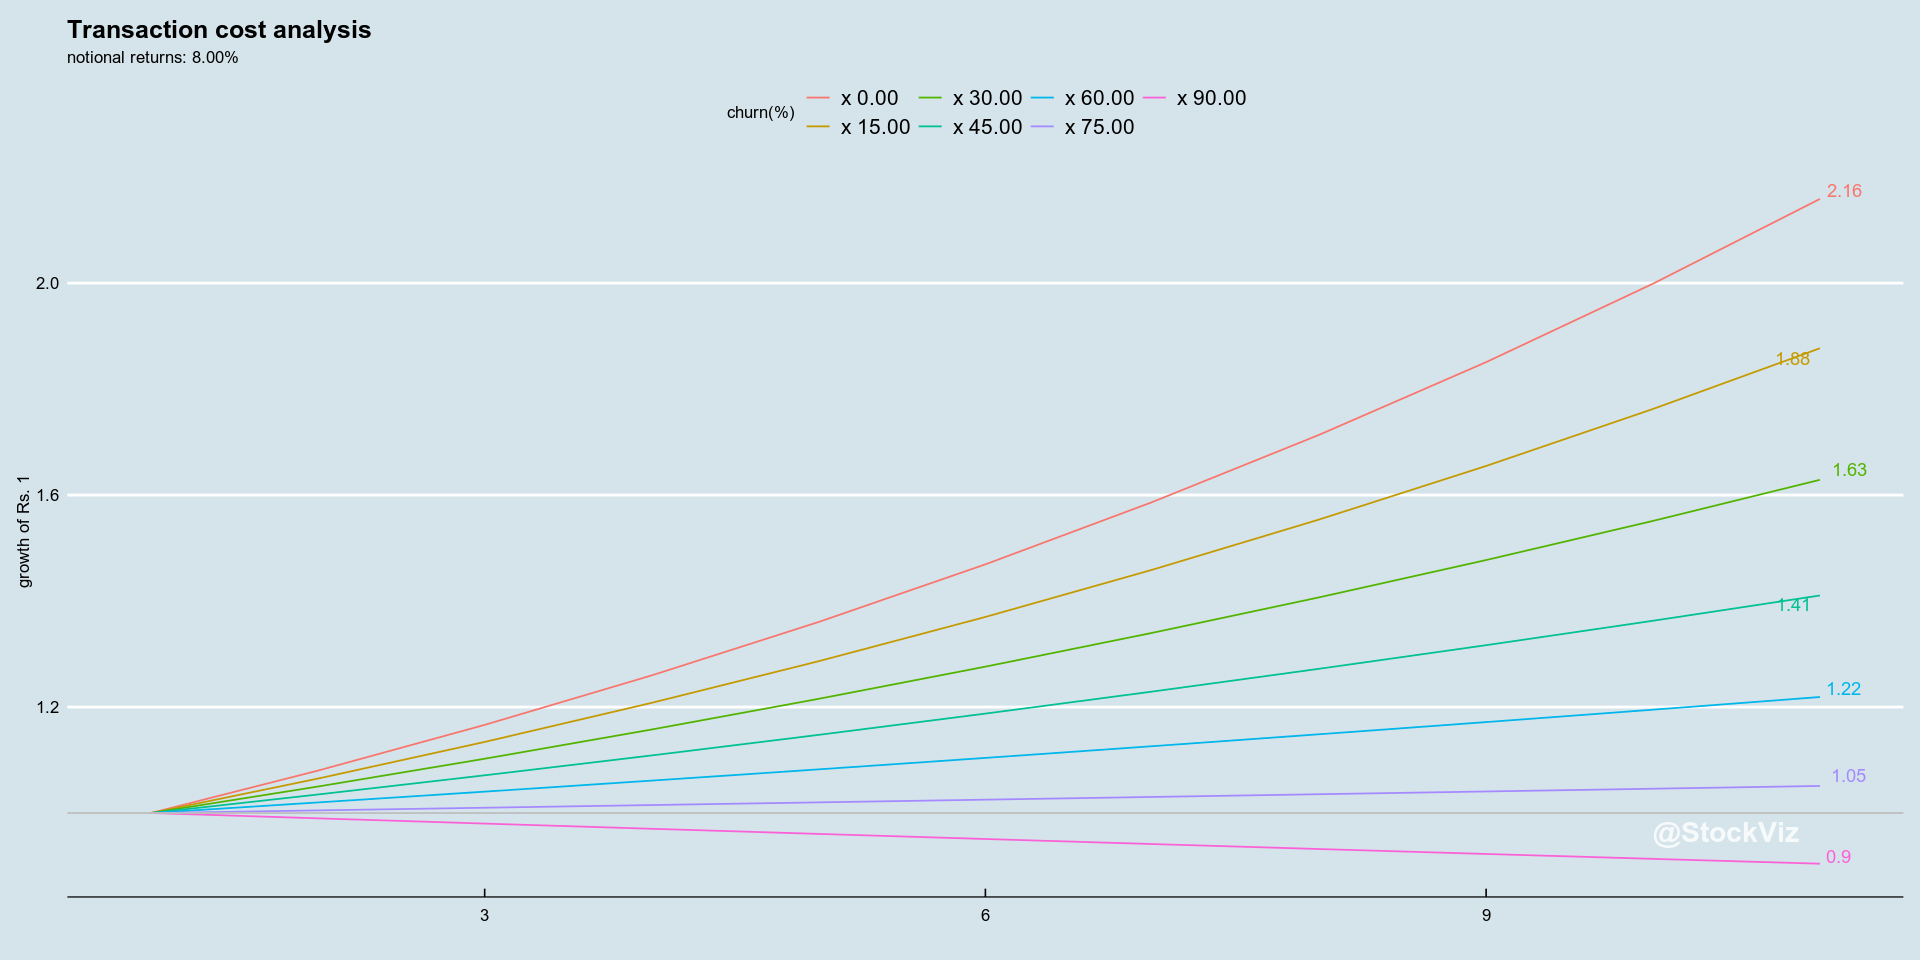

In [22]:
doScenarioAnalysis(0.08)

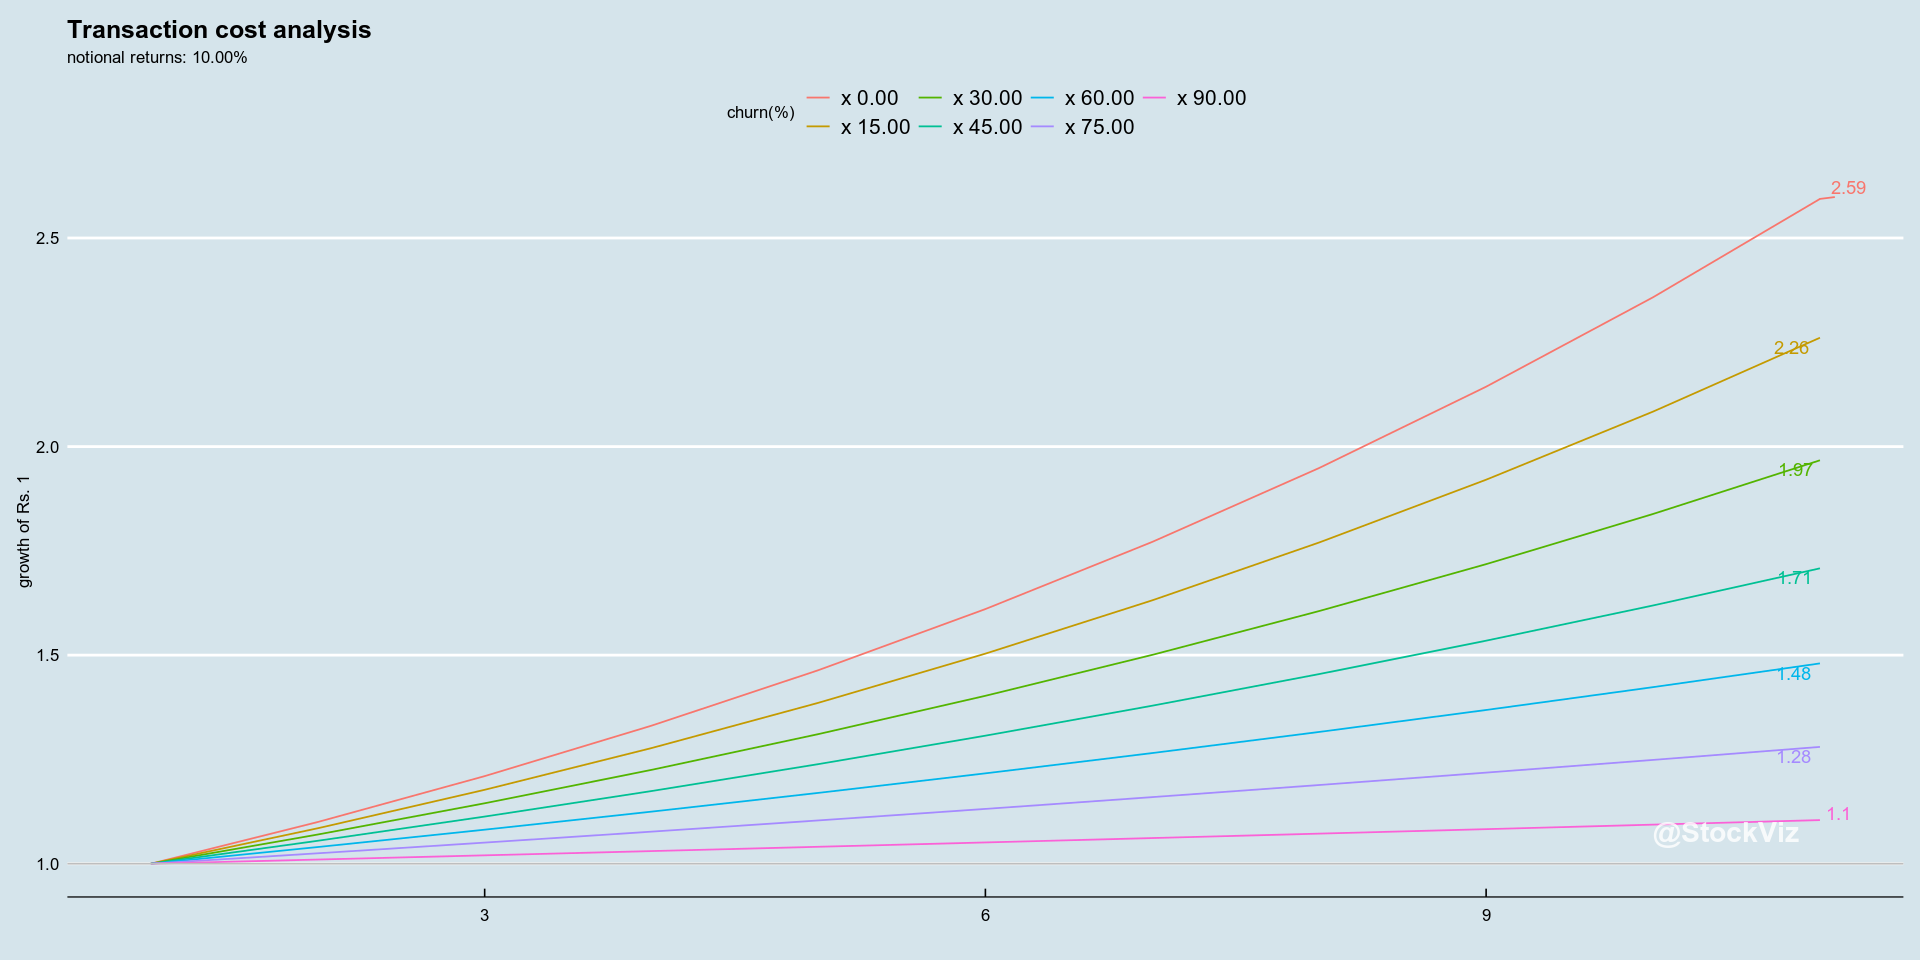

In [23]:
doScenarioAnalysis(0.1)

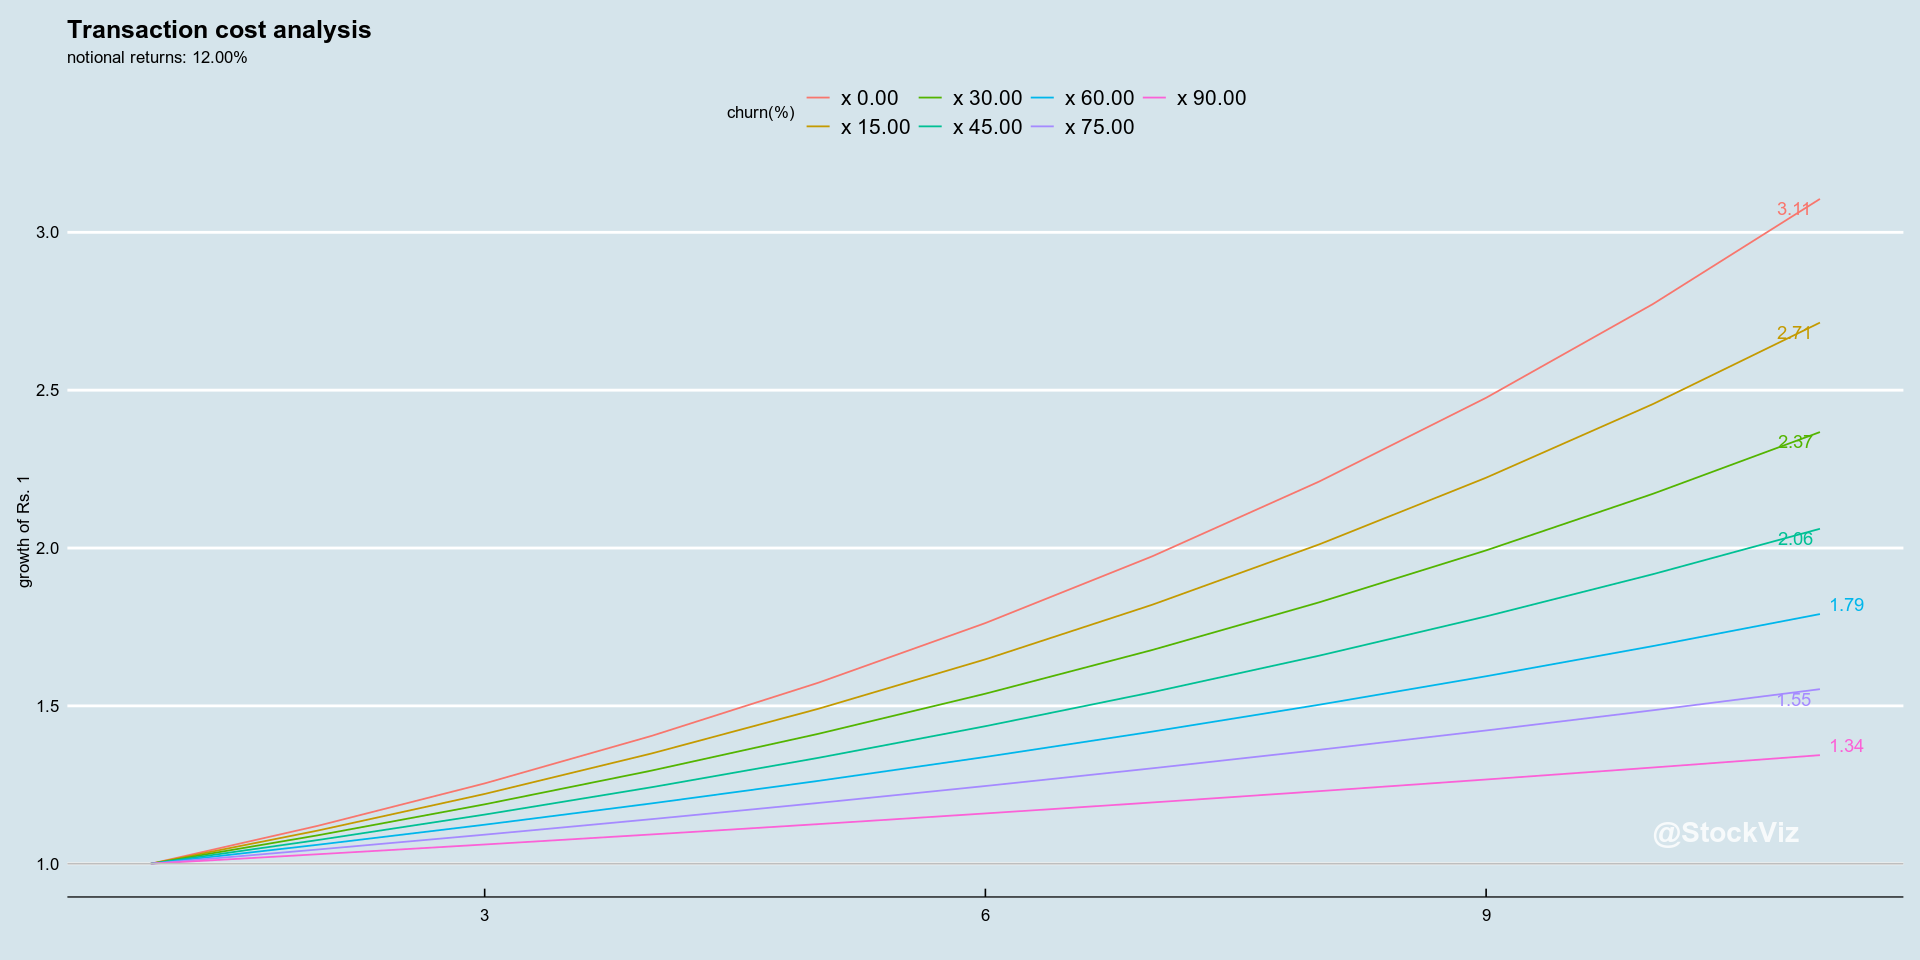

In [24]:
doScenarioAnalysis(0.12)

This notebook was created using [pluto](https://pluto.studio). Thank you for playing fair!